Mal die Daten für die 6 aktivsten Nutzer holen...

In [1]:
from src.data.dataset_functions import make_dataframe_from_rawcsv

dataFrame = make_dataframe_from_rawcsv()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/10 07:30:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
dataFrame.printSchema()
dataFrame.show(1)

root
 |-- timestamp: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- pixel_color: string (nullable = true)
 |-- coordinate: string (nullable = true)

+--------------------+--------------------+-----------+----------+
|           timestamp|             user_id|pixel_color|coordinate|
+--------------------+--------------------+-----------+----------+
|2022-04-04 04:38:...|vKtmwRQwAYtw5poO4...|    #FF3881|  804,1992|
+--------------------+--------------------+-----------+----------+
only showing top 1 row



In [3]:
import pyspark.sql.functions as F
from src.features.feature_functions import stamp2time

#
#mappedFrame = dataFrame.rdd.map(
#    lambda x:
#    (x['user_id'],int(x['coordinate'].split(",")[0]),int(x['coordinate'].split(",")[1]),int(stamp2time(x['timestamp'])),x['pixel_color'])
#).toDF(['user_id','x','y','t','pixel_color'])

#mappedFrame.printSchema()
#mappedFrame.show(2)

shortenedFrame = dataFrame.withColumn("timestamp",dataFrame.timestamp.substr(0,19))
stampedFrame = shortenedFrame.withColumn("timestamp",F.unix_timestamp("timestamp"))
stampedFrame.show(1)


+----------+--------------------+-----------+----------+
| timestamp|             user_id|pixel_color|coordinate|
+----------+--------------------+-----------+----------+
|1649047095|vKtmwRQwAYtw5poO4...|    #FF3881|  804,1992|
+----------+--------------------+-----------+----------+
only showing top 1 row



In [4]:
mints = stampedFrame.select('timestamp').rdd.min()[0]

In [6]:
mints

1649047095

In [5]:
normalizedFrame = stampedFrame.withColumn('timestamp',(stampedFrame['timestamp'] - mints))
normalizedFrame.show()

+---------+--------------------+-----------+----------+
|timestamp|             user_id|pixel_color|coordinate|
+---------+--------------------+-----------+----------+
|        0|vKtmwRQwAYtw5poO4...|    #FF3881|  804,1992|
|        0|eoZO4uYgBzVoDR0Rb...|    #FFFFFF|  1667,616|
|        0|Mdd6j8t/24pCeslV3...|    #D4D7D9|   392,467|
|        0|xHWcOdv98PR7yQNKD...|    #000000|   21,1691|
|        0|hI0Z36Jzkw+coR+im...|    #515252|  971,1026|
|        0|0HZIIDPh4Cc14RA0a...|    #2450A4|  1663,694|
|        0|+ZKQz5UNhS1XIM8+v...|    #FFFFFF|  144,1574|
|        0|zHTjoBBetnY09LtuW...|    #FFD635|    268,97|
|        0|FYp7Xfdov9uD16kL8...|    #000000|  1406,671|
|        0|8bnQE1zaAm+73c8Qy...|    #898D90|  1427,615|
|        0|YztTX+FnX3/VNQtGR...|    #898D90|  1431,656|
|        0|DwjRHXciEU1FdjbRh...|    #FFFFFF|   502,541|
|        0|nU9FB2/Svv22wH1qR...|    #2450A4|   48,1574|
|        0|GSsX/sFt//9t65ARX...|    #898D90|  1442,627|
|        0|G1PxLxJlgkcf9w51U...|    #E4ABFF| 117

In [6]:
splittedFrame = normalizedFrame.select('user_id',F.split('coordinate',',').getItem(0).cast('int').alias('x'),F.split('coordinate',',').getItem(1).cast('int').alias('y'),F.col('timestamp').alias('t'),'pixel_color')
splittedFrame.show(1)

+--------------------+---+----+---+-----------+
|             user_id|  x|   y|  t|pixel_color|
+--------------------+---+----+---+-----------+
|vKtmwRQwAYtw5poO4...|804|1992|  0|    #FF3881|
+--------------------+---+----+---+-----------+
only showing top 1 row



In [7]:

groupedFrame = splittedFrame.groupBy('user_id').agg(F.count('x').alias('count'),F.collect_list('x'),F.collect_list('y'),F.collect_list('t'),F.collect_list('pixel_color')).orderBy(F.count('x').desc())
groupedFrame.printSchema()
groupedFrame.show(5)

root
 |-- user_id: string (nullable = true)
 |-- count: long (nullable = false)
 |-- collect_list(x): array (nullable = false)
 |    |-- element: integer (containsNull = false)
 |-- collect_list(y): array (nullable = false)
 |    |-- element: integer (containsNull = false)
 |-- collect_list(t): array (nullable = false)
 |    |-- element: long (containsNull = false)
 |-- collect_list(pixel_color): array (nullable = false)
 |    |-- element: string (containsNull = false)



+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
|             user_id|count|     collect_list(x)|     collect_list(y)|     collect_list(t)|collect_list(pixel_color)|
+--------------------+-----+--------------------+--------------------+--------------------+-------------------------+
|AxBTmhBMbr1sbDw/2...|   20|[1447, 1617, 655,...|[5, 16, 1896, 191...|[184, 1417, 1726,...|     [#FFA800, #FF4500...|
|FjHp8Fg+uuheibUWk...|   15|[998, 998, 998, 9...|[1466, 1466, 1466...|[420, 60, 420, 18...|     [#000000, #000000...|
|X8gpDfO6+Z87SKKTy...|   15|[902, 939, 914, 9...|[1844, 1858, 1836...|[1422, 1727, 212,...|     [#FFA800, #00756F...|
|DIECtVqoJqBlL6A0C...|   15|[920, 958, 936, 1...|[1852, 1831, 1861...|[1804, 2106, 293,...|     [#000000, #BE0039...|
|VmiTfdqG3P1MlZokx...|   15|[907, 1631, 935, ...|[1860, 220, 1847,...|[347, 44, 44, 216...|     [#51E9F4, #FFD635...|
+--------------------+-----+--------------------+-------

In [10]:
groupedFrame.count()

733458

In [8]:
dataCollection = groupedFrame.take(1)

In [9]:
print(dataCollection)

[Row(user_id='AxBTmhBMbr1sbDw/2liFySQ4h6lH1bZSyjS9RtcBxvMyafVj+e2grv9teqbU9JkFDCPlgIfWH+L2CzKeSBdB4w==', count=20, collect_list(x)=[1447, 1617, 655, 612, 1575, 1287, 1636, 1926, 658, 1310, 1403, 1299, 777, 586, 1741, 584, 1611, 1765, 788, 656], collect_list(y)=[5, 16, 1896, 1917, 7, 8, 21, 19, 14, 10, 2, 20, 8, 1931, 10, 26, 33, 8, 11, 1884], collect_list(t)=[184, 1417, 1726, 1726, 1726, 801, 492, 801, 2035, 1109, 2344, 2653, 2344, 2653, 2344, 3577, 3269, 3577, 2961, 2961], collect_list(pixel_color)=['#FFA800', '#FF4500', '#B44AC0', '#E4ABFF', '#FFA800', '#3690EA', '#FFFFFF', '#BE0039', '#FF4500', '#2450A4', '#FFA800', '#FFFFFF', '#FFA800', '#9C6926', '#FFA800', '#000000', '#2450A4', '#FFA800', '#000000', '#E4ABFF'])]


[[[1447, 1617, 655, 612, 1575, 1287, 1636, 1926, 658, 1310, 1403, 1299, 777, 586, 1741, 584, 1611, 1765, 788, 656], [5, 16, 1896, 1917, 7, 8, 21, 19, 14, 10, 2, 20, 8, 1931, 10, 26, 33, 8, 11, 1884], [184, 1417, 1726, 1726, 1726, 801, 492, 801, 2035, 1109, 2344, 2653, 2344, 2653, 2344, 3577, 3269, 3577, 2961, 2961]]]


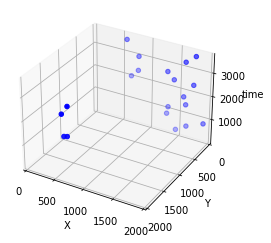

In [10]:
from src.visualization.visuialization_functions import plot_userlist_pixel

userpixel = []
for row in dataCollection:
    user_id , count ,xs , ys , ts , pixel_color = list(row)
    userpixel.append([xs,ys,ts])
print(userpixel)
plot_userlist_pixel(userpixel)
